In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.classes.function import path_weight
import matplotlib.pyplot as plt
import pickle

In [2]:
trips_df = pd.read_csv('data/2013-09-01_trip_data_manhattan.csv').drop(columns='id')
nodes_df = pd.read_csv('data/nyc_nodes_manhattan.csv').drop(columns='Unnamed: 0')
arcs_df = pd.read_csv('data/nyc_links_manhattan.csv').drop(columns='Unnamed: 0')

In [6]:
# Construct the street network
G = nx.Graph()
for l in range(len(nodes_df)):
    G.add_node(l)
for index, row in arcs_df.iterrows():
    i = row['start']
    j = row['end']
    G.add_edge(i, j, weight = row['trip_time'])

In [7]:
def compute_distance(lat1,lon1,lat2,lon2):
    '''Calculate the Euclidean distance between two locations.'''
    R = 6371  # Radius of the earth in km
    return R * np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2) * np.pi / 180

In [32]:
do_pu_pair =[]
for i in pd.unique(trips_df.end_node):
    for j in pd.unique(trips_df.start_node):
        do_pu_pair.append((i, j))

In [34]:
# Dictionaries to store the shortest path and travel time
time_map = dict()
shortest_paths = dict()
for d,p in do_pu_pair:
    try:
        shortest_path = nx.shortest_path(G, source=d, target=p, weight = 'weight')
        shortest_paths[(d, p)] = shortest_path
        time_map[(d, p)] = path_weight(G, shortest_path, weight="weight")
    # Use the straight-line distance to estimate travel time if there's no path in the street network
    except nx.NetworkXNoPath:
        time_map[(d, p)] = compute_distance(nodes_df.loc[d, 'lat'], nodes_df.loc[d, 'lon'],
                                        nodes_df.loc[p, 'lat'], nodes_df.loc[p, 'lon']) / (30/60)

(array([881757., 992177., 767089., 628803., 508174., 390805., 204540.,
         86357.,  29436.,   4808.]),
 array([  0. ,  22.2,  44.4,  66.6,  88.8, 111. , 133.2, 155.4, 177.6,
        199.8, 222. ]),
 <BarContainer object of 10 artists>)

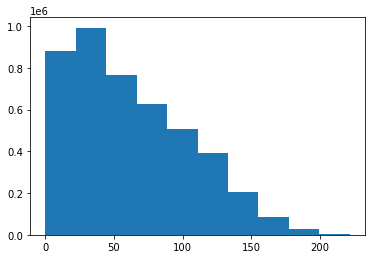

In [36]:
# Take a look at the distribution of travel time
plt.hist(list(time_map.values()))

In [38]:
# Store the location-time dictionary in a pickel file
with open('data/time_map.pkl', 'wb') as f:
    pickle.dump(time_map, f)

Run one day's data

In [ ]:
# Save the results
def max_match(start_time, end_time, trips_df, max_waiting_time):
    # filter trips by time window of interest
    trips = trips_df.copy()
    trips = trips[(trips.start_time >= start_time) & 
                  (trips.start_time + trips.trip_time <= end_time)].copy()
    trips.start_time = trips.start_time - start_time

    # create a dictionary to map the location pairs to trip time
    loc_time = dict()
    for index, row in arcs_df.iterrows():
        i = row['start']
        j = row['end']
        delay = row['trip_time']
        loc_time[(i, j)] = delay
    # Intialize nodes and edges
    DO_nodes = list()
    PU_nodes = list()
    edges = list()
    # Initialize a dict that maps a PU node to a DO node
    PUtoDO = dict()
    # Specify nodes - each node is a tuple of (location_id, time, trip_id, "DO"/"PU")
    for index, row in trips.iterrows():
        s = row['start_node']
        t = row['end_node']
        s_t = row['start_time']
        t_t = s_t + row['trip_time']
        DO_node = (int(t), t_t, index, 'DO')
        PU_node = (int(s), s_t, index, 'PU')
        DO_nodes.append(DO_node)
        PU_nodes.append(PU_node)
        PUtoDO[PU_node] = DO_node
    DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
    PU_nodes = sorted(PU_nodes, key = lambda x: x[1])
    
    # Specify edges
    for DO_node in DO_nodes:
        for PU_node in PU_nodes:
            if PU_node[1] > DO_node[1] + max_waiting_time:
                break
            else:
                if PU_node[1] >= DO_node[1]:
                    time = times[(DO_node[0], PU_node[0])]
                    if ((PU_node[1] - DO_node[1]) - max_waiting_time <= time) & (time <= (PU_node[1] - DO_node[1])):
                        edges.append((DO_node, PU_node))
    
    # load the model
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(DO_nodes, bipartite=0)
    B.add_nodes_from(PU_nodes, bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(edges)
    
    top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    match = nx.bipartite.maximum_matching(B, top_nodes)

    return match

match = max_match(0, 1440, trips_df, 10)
with open('data/day_match.pkl', 'wb') as f:
    pickle.dump(match, f)

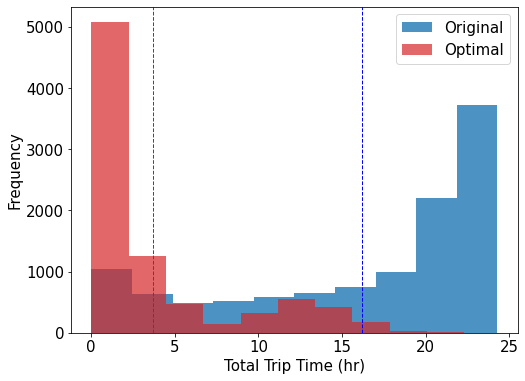

In [46]:
FONT_SIZE = 15
# Total Trip Time
plt.rcParams.update({'font.size': FONT_SIZE})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(og_total_time, label = 'Original', alpha = 0.8)
plt.hist(opt_total_time, color ='tab:red', label = 'Optimal', alpha = 0.7)
ax.set_xlabel('Total Trip Time (hr)')
ax.set_ylabel('Frequency')
min_ylim, max_ylim = plt.ylim()
plt.axvline(np.mean(og_total_time), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(opt_total_time), color='red', linestyle='dashed', linewidth=1)
ax.legend(loc="best", prop={'size': FONT_SIZE});
# fig.savefig('visuals/total_trip_time.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

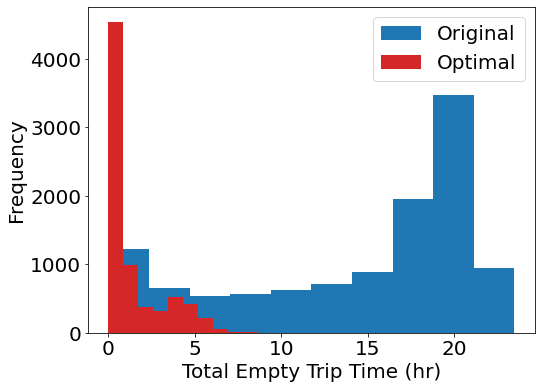

In [79]:
# Total Empty Trip Time
plt.rcParams.update({'font.size': FONT_SIZE})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(og_empty_time, label = 'Original')
plt.hist(opt_empty_time, color ='tab:red', label = 'Optimal')
ax.set_xlabel('Total Empty Trip Time (hr)')
ax.set_ylabel('Frequency')
ax.legend(loc="best", prop={'size': FONT_SIZE});
# fig.savefig('visuals/empty_trip_time.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

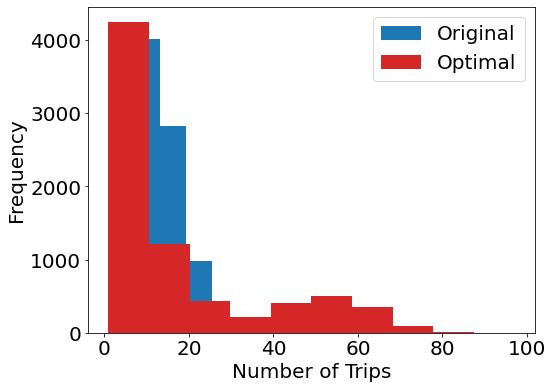

In [80]:
# Number of Trips
plt.rcParams.update({'font.size': FONT_SIZE})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(og_total_num_trips, label = 'Original')
plt.hist(opt_total_num_trips, color ='tab:red', label = 'Optimal')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Frequency')
ax.legend(loc="best", prop={'size': FONT_SIZE});
fig.savefig('visuals/num_trip.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

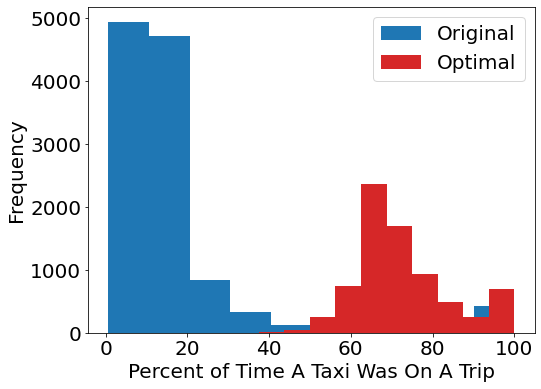

In [36]:
# On-Trip Percentage
plt.rcParams.update({'font.size': FONT_SIZE})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(np.array(og_on_trip) * 100 , label = 'Original')
plt.hist(np.array(opt_on_trip) * 100, color ='tab:red', label = 'Optimal')
ax.set_xlabel('Percent of Time A Taxi Was On A Trip')
ax.set_ylabel('Frequency')
ax.legend(loc="best", prop={'size': FONT_SIZE});
fig.savefig('visuals/on_trip_pct.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)